<a href="https://colab.research.google.com/github/larasauser/2024_MLEES/blob/main/Project/project_script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**# Machine learning Project - Sauser Lara**
## *Filling gaps in NDVI images using CNN and Diffusion models*

[Ajouter une image d'illustration]

##Main steps :


1.   Gather dataset
2.   Split the dataset
3.   Create the CNN alorithm
4.   Create the Dissolution model
5.   Evaluate them (RMSE ?)



### 1. Loading the data and separate them into smaller images (32x32 px)
--- This should be done only once per image set because it takes time ---

--- New image set should be used after this step ---



In [1]:
#Dataset stored on Google Drive
from google.colab import drive
drive.mount('/content/drive')


import os
folder_path = '/content/drive/My Drive/NDVI_Landsat8_10/'

Mounted at /content/drive


Let's visualise some of our original images.

In [4]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 48.4 MB/s eta 0:00:00


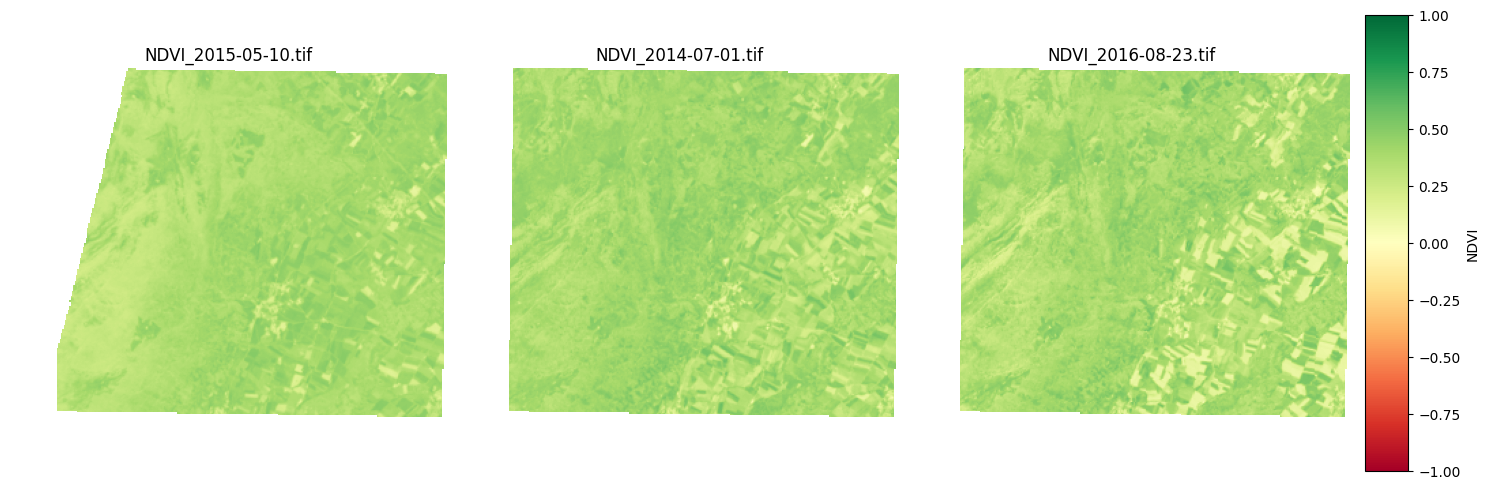

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.gridspec import GridSpec
import rasterio
import numpy as np
# Get a list of files in the directory
tif_files = [f for f in os.listdir(folder_path) if f.endswith('.tif')]

# Specify the indices of images you want to display
selected_indices = [10, 50, 100 ]

# Safeguard: Ensure indices are within range
selected_files = [tif_files[i] for i in selected_indices if i < len(tif_files)]

# Set up a GridSpec layout
fig = plt.figure(figsize=(15, 5))
gs = GridSpec(1, len(selected_files) + 1, width_ratios=[1] * len(selected_files) + [0.1])  # Extra column for the colorbar

axes = [fig.add_subplot(gs[0, i]) for i in range(len(selected_files))]  # Subplots for images
cbar_ax = fig.add_subplot(gs[0, -1])  # Separate subplot for the colorbar

for i, file_name in enumerate(selected_files):
    file_path = os.path.join(folder_path, file_name)

    # Open the GeoTIFF file
    with rasterio.open(file_path) as src:
        ndvi_data = src.read(1)  # Read the first band (NDVI values)
        ndvi_data = np.where(ndvi_data == src.nodata, np.nan, ndvi_data)  # Handle NoData values

    # Plot the NDVI data in the subplot
    im = axes[i].imshow(ndvi_data, cmap='RdYlGn', vmin=-1, vmax=1)
    axes[i].set_title(file_name)
    axes[i].axis('off')

# Add the shared colorbar in the dedicated axis
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
cbar.set_label('NDVI')

# Adjust layout
plt.tight_layout()
plt.show()

To have more images and to reduce computational cost, we decide to devide them into sub-images of 32x32 pixels.

In [ ]:
#pip install Pillow

In [7]:
from PIL import Image
img=Image.open('/content/drive/My Drive/NDVI_Landsat8_10/NDVI_2023-11-08.tif')
img_width, img_height = img.size
print(img_width)
print(img_height)


321
256


In [ ]:
from PIL import Image
import os
def split_image(image_path, output_folder, sub_image_size=(32, 32)):
    # Open image
    img = Image.open(image_path)
    img_width, img_height = img.size

    # Image count
    count = 0

    # Division
    for i in range(0, img_width, sub_image_size[0]):
        for j in range(0, img_height, sub_image_size[1]):
            # Cutting box
            box = (i, j, i + sub_image_size[0], j + sub_image_size[1])
            # Cutting
            sub_image = img.crop(box)
            # Verification (size)
            if sub_image.size[0] > 0 and sub_image.size[1] > 0:
                # Saving
                sub_image.save(os.path.join(output_folder, f"{os.path.splitext(os.path.basename(image_path))[0]}_sub_image_{count}.tif"))
                count += 1
    print(count)

def process_all_images(input_folder, output_folder):
    # List all tif file in input folder
    for filename in os.listdir(input_folder):
        if filename.endswith('.tif'):
            image_path = os.path.join(input_folder, filename)
            print(f"Image in treatment : {filename}")
            split_image(image_path, output_folder)


In [ ]:
#Split our images
output_folder = '/content/drive/My Drive/NDVI_Landsat8_10/split'
process_all_images(folder_path, output_folder)

Image in treatment : NDVI_2013-04-18.tif
99
Image in treatment : NDVI_2013-11-12.tif
99
Image in treatment : NDVI_2013-11-28.tif
99
Image in treatment : NDVI_2013-12-30.tif
99
Image in treatment : NDVI_2014-03-20.tif
99
Image in treatment : NDVI_2014-10-30.tif
99
Image in treatment : NDVI_2014-06-08.tif
99
Image in treatment : NDVI_2015-02-19.tif
99
Image in treatment : NDVI_2015-04-08.tif
99
Image in treatment : NDVI_2015-04-24.tif
99
Image in treatment : NDVI_2015-05-10.tif
99
Image in treatment : NDVI_2015-08-30.tif
99
Image in treatment : NDVI_2015-12-20.tif
99
Image in treatment : NDVI_2016-04-10.tif
99
Image in treatment : NDVI_2016-10-03.tif
99
Image in treatment : NDVI_2016-12-06.tif
99
Image in treatment : NDVI_2017-03-28.tif
99
Image in treatment : NDVI_2017-01-23.tif
99
Image in treatment : NDVI_2017-04-29.tif
99
Image in treatment : NDVI_2017-04-13.tif
99
Image in treatment : NDVI_2018-06-19.tif
99
Image in treatment : NDVI_2018-10-09.tif
99
Image in treatment : NDVI_2018-1

Images are now splitted. We now have 11'880 images to use for our model.

### 2. Convolutional Neural Network (CNN)

In [8]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
#drive.flush_and_unmount('/content/drive')

Drive not mounted, so nothing to flush and unmount.


#### 2.0 Data Augmentation ???

#### 2.1 Split the dataset into train, test and validation set

In [9]:
import os
import random
import shutil

In [10]:
# Define the source directory and the new directories for train, validation, and test sets
source_dir = '/content/drive/My Drive/NDVI_Landsat8_10/split'
train_dir = '/content/drive/My Drive/NDVI_Landsat8_10/train'
val_dir = '/content/drive/My Drive/NDVI_Landsat8_10/validation'
test_dir = '/content/drive/My Drive/NDVI_Landsat8_10/test'

In [11]:
# Create the new directories if they don't exist
for dir in [train_dir, val_dir, test_dir]:
    if not os.path.exists(dir):
        os.makedirs(dir)

In [12]:
# Get all image files from the source directory
all_images = [f for f in os.listdir(source_dir) if f.endswith(('.tif'))]

In [13]:
# Shuffle the list of images
random.shuffle(all_images)

In [14]:
len(all_images)

11880

In [15]:
# Calculate the number of images for each set
total_images = len(all_images)
train_split = int(0.7 * total_images)
val_split = int(0.2 * total_images)

In [16]:
# Split the images into train, validation, and test sets
train_images = all_images[:train_split]
val_images = all_images[train_split:train_split+val_split]
test_images = all_images[train_split+val_split:]

In [17]:
# Function to copy images to their respective directories
def copy_images(image_list, destination):
    for image in image_list:
        src = os.path.join(source_dir, image)
        dst = os.path.join(destination, image)
        shutil.copy(src, dst)


In [18]:
# Copy the images to their respective directories
copy_images(train_images, train_dir)
copy_images(val_images, val_dir)
copy_images(test_images, test_dir)

In [19]:
print(f"Total images: {total_images}")
print(f"Training images: {len(train_images)}")
print(f"Validation images: {len(val_images)}")
print(f"Test images: {len(test_images)}")

Total images: 11880
Training images: 8316
Validation images: 2376
Test images: 1188


#### 2.2 Create fake holes in images for training set

In [20]:
import os
import numpy as np
import cv2
from tqdm import tqdm

In [16]:
# Define the paths
train_dir = '/content/drive/My Drive/NDVI_Landsat8_10/train'
output_dir = os.path.join(train_dir, 'train_with_holes')

I start with a simple hole : a rectangle

In [17]:
def add_fake_holes(image, num_holes=4, max_hole_size=12):
    """
    Add fake holes to an image to simulate cloud coverage.

    Args:
        image (numpy array): Input image as a NumPy array.
        num_holes (int): Number of fake holes to add.
        max_hole_size (int): Maximum size (in pixels) of each hole.

    Returns:
        numpy array: Image with fake holes applied.
    """
    image_with_holes = image.copy()
    height, width = image.shape[:2]

    for _ in range(num_holes):
        # Randomly select a center for the hole
        x_center = np.random.randint(0, width)
        y_center = np.random.randint(0, height)

        # Randomly determine the size of the hole
        hole_width = np.random.randint(1, max_hole_size)
        hole_height = np.random.randint(1, max_hole_size)

        # Create the hole (set pixel values to zero)
        x_start = max(0, x_center - hole_width // 2)
        x_end = min(width, x_center + hole_width // 2)
        y_start = max(0, y_center - hole_height // 2)
        y_end = min(height, y_center + hole_height // 2)

        image_with_holes[y_start:y_end, x_start:x_end] = np.nan  # Simulate cloud (masked area)

    return image_with_holes


In [20]:
import os
import rasterio
import numpy as np

def process_and_add_fake_holes(train_dir, output_dir):
    """
    Iterate over all GeoTIFF images in a directory, add fake holes, and save the processed images.
    Args:
        train_dir (str): Directory containing input GeoTIFF images.
        output_dir (str): Directory to save processed GeoTIFF images.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Iterate over all images in the train_dir
    for filename in os.listdir(train_dir):
        if filename.endswith('.tif'):
            input_path = os.path.join(train_dir, filename)
            output_path = os.path.join(output_dir, filename)

            try:
                # Load the image using rasterio
                with rasterio.open(input_path) as src:
                    image = src.read(1)  # Read the first band
                    meta = src.meta.copy()  # Copy metadata

                # Add fake holes
                image_with_holes = add_fake_holes(image)

                # Update the metadata (e.g., for nodata values)
                meta.update(dtype='float32', nodata=np.nan)

                # Save the processed image
                with rasterio.open(output_path, 'w', **meta) as dst:
                    dst.write(image_with_holes, 1)  # Write to the first band

                #print(f"Processed and saved: {output_path}")

            except Exception as e:
                print(f"Failed to process {filename}: {e}")


In [21]:
process_and_add_fake_holes(train_dir, output_dir)

Failed to process NDVI_2022-02-13 (1)_sub_image_87.tif: Read failed. See previous exception for details.
Failed to process NDVI_2013-07-14_sub_image_14.tif: Read failed. See previous exception for details.
Failed to process NDVI_2015-05-10_sub_image_1.tif: Read failed. See previous exception for details.
Failed to process NDVI_2013-11-12_sub_image_17.tif: Read failed. See previous exception for details.
Failed to process NDVI_2022-02-13 (1)_sub_image_83.tif: Read failed. See previous exception for details.
Failed to process NDVI_2016-08-23_sub_image_5.tif: Read failed. See previous exception for details.
Failed to process NDVI_2013-07-14_sub_image_10.tif: Read failed. See previous exception for details.
Failed to process NDVI_2018-06-26_sub_image_72.tif: Read failed. See previous exception for details.
Failed to process NDVI_2022-09-18_sub_image_18.tif: Read failed. See previous exception for details.
Failed to process NDVI_2023-08-20_sub_image_50.tif: Read failed. See previous excepti

#### 2.3 Create holes in image of the validation set

In [23]:
import os
import numpy as np
import cv2
from tqdm import tqdm

In [24]:
# Define the paths
val_dir = '/content/drive/My Drive/NDVI_Landsat8_10/validation'
output_dir = os.path.join(val_dir, 'val_with_holes')

In [25]:
# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

In [26]:
import os
import rasterio
import numpy as np

def process_and_add_fake_holes(val_dir, output_dir):
    """
    Iterate over all GeoTIFF images in a directory, add fake holes, and save the processed images.
    Args:
        train_dir (str): Directory containing input GeoTIFF images.
        output_dir (str): Directory to save processed GeoTIFF images.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Iterate over all images in the train_dir
    for filename in os.listdir(val_dir):
        if filename.endswith('.tif'):
            input_path = os.path.join(val_dir, filename)
            output_path = os.path.join(output_dir, filename)

            try:
                # Load the image using rasterio
                with rasterio.open(input_path) as src:
                    image = src.read(1)  # Read the first band
                    meta = src.meta.copy()  # Copy metadata

                # Add fake holes
                image_with_holes = add_fake_holes(image)

                # Update the metadata (e.g., for nodata values)
                meta.update(dtype='float32', nodata=np.nan)

                # Save the processed image
                with rasterio.open(output_path, 'w', **meta) as dst:
                    dst.write(image_with_holes, 1)  # Write to the first band

                #print(f"Processed and saved: {output_path}")

            except Exception as e:
                print(f"Failed to process {filename}: {e}")


In [27]:
process_and_add_fake_holes(val_dir, output_dir)

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:355: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Failed to process NDVI_2014-06-08_sub_image_41.tif: Read failed. See previous exception for details.
Failed to process NDVI_2021-10-17_sub_image_19.tif: Read failed. See previous exception for details.
Failed to process NDVI_2022-09-18_sub_image_79.tif: Read failed. See previous exception for details.
Failed to process NDVI_2023-01-31_sub_image_44.tif: Read failed. See previous exception for details.
Failed to process NDVI_2013-04-18_sub_image_0.tif: Read failed. See previous exception for details.


/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:365: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


Failed to process NDVI_2022-01-21_sub_image_25.tif: Read failed. See previous exception for details.


Failed to process NDVI_2015-12-20_sub_image_43.tif: Read failed. See previous exception for details.


Failed to process NDVI_2015-12-20_sub_image_30.tif: Read failed. See previous exception for details.
Failed to process NDVI_2022-03-26_sub_image_85.tif: Read failed. See previous exception for details.
Failed to process NDVI_2015-08-21_sub_image_10.tif: Read failed. See previous exception for details.
Failed to process NDVI_2023-08-20_sub_image_32.tif: Read failed. See previous exception for details.


Failed to process NDVI_2022-07-07_sub_image_44.tif: Read failed. See previous exception for details.
Failed to process NDVI_2015-07-04 (1)_sub_image_80.tif: Read failed. See previous exception for details.
Failed to process NDVI_2022-09-18_sub_image_81.tif: Read failed. See previous exception for details.
Failed to process NDVI_2018-06-19_sub_image_19.tif: Read failed. See previous exception for details.
Failed to process NDVI_2023-04-05_sub_image_4.tif: Read failed. See previous exception for details.
Failed to process NDVI_2018-06-26_sub_image_1.tif: Read failed. See previous exception for details.
Failed to process NDVI_2016-08-07 (1)_sub_image_85.tif: Read failed. See previous exception for details.
Failed to process NDVI_2023-06-24 (1)_sub_image_86.tif: Read failed. See previous exception for details.


Failed to process NDVI_2021-09-06_sub_image_6.tif: Read failed. See previous exception for details.
Failed to process NDVI_2023-04-05 (1)_sub_image_7.tif: Read failed. See previous exception for details.
Failed to process NDVI_2018-10-25_sub_image_33.tif: Read failed. See previous exception for details.
Failed to process NDVI_2019-02-05 (1)_sub_image_86.tif: Read failed. See previous exception for details.


#### 2.4 Building the CNN

In [28]:
#Load the training data
from google.colab import drive
drive.mount('/content/drive')

train_dir = '/content/drive/My Drive/NDVI_Landsat8_10/train'
train_with_holes_dir = '/content/drive/My Drive/NDVI_Landsat8_10/train/train_with_holes'

val_dir = '/content/drive/My Drive/NDVI_Landsat8_10/validation'
val_with_holes_dir = '/content/drive/My Drive/NDVI_Landsat8_10/validation/val_with_holes'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
#Dependencies
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.gridspec import GridSpec
import rasterio
import os
import cv2
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from PIL import Image

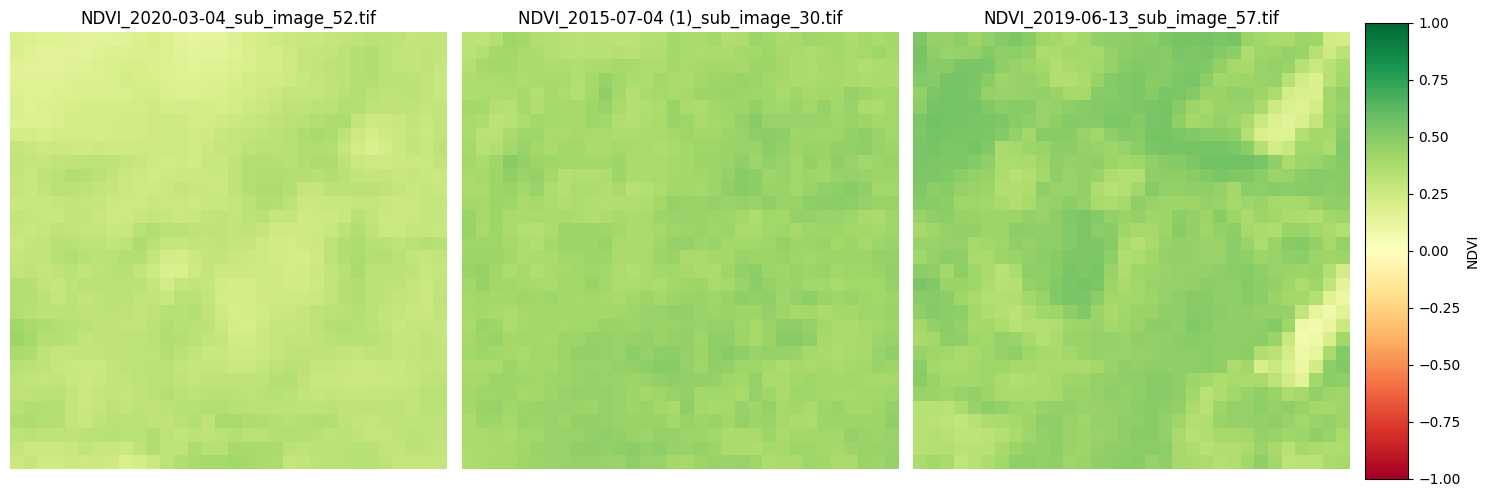

In [30]:
# Get a list of files in the directory
tif_files = [f for f in os.listdir(train_dir) if f.endswith('.tif')]

# Specify the indices of images you want to display
selected_indices = [0, 5, 500 ]

# Safeguard: Ensure indices are within range
selected_files = [tif_files[i] for i in selected_indices if i < len(tif_files)]

# Set up a GridSpec layout
fig = plt.figure(figsize=(15, 5))
gs = GridSpec(1, len(selected_files) + 1, width_ratios=[1] * len(selected_files) + [0.1])  # Extra column for the colorbar

axes = [fig.add_subplot(gs[0, i]) for i in range(len(selected_files))]  # Subplots for images
cbar_ax = fig.add_subplot(gs[0, -1])  # Separate subplot for the colorbar

for i, file_name in enumerate(selected_files):
    file_path = os.path.join(train_dir, file_name)

    # Open the GeoTIFF file
    with rasterio.open(file_path) as src:
        ndvi_data = src.read(1)  # Read the first band (NDVI values)
        ndvi_data = np.where(ndvi_data == src.nodata, np.nan, ndvi_data)  # Handle NoData values

    # Plot the NDVI data in the subplot
    im = axes[i].imshow(ndvi_data, cmap='RdYlGn', vmin=-1, vmax=1)
    axes[i].set_title(file_name)
    axes[i].axis('off')

# Add the shared colorbar in the dedicated axis
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
cbar.set_label('NDVI')

# Adjust layout
plt.tight_layout()
plt.show()


In [31]:
# Get a list of all files in the directory
file_list = os.listdir(train_dir)

# Get the number of files
num_files = len(file_list)

# Print the number of files
print(f"There are {num_files} files in the directory.")

There are 8317 files in the directory.


In [32]:
# Get a list of all files in the directory
file_list = os.listdir(train_with_holes_dir)

# Get the number of files
num_files = len(file_list)

# Print the number of files
print(f"There are {num_files} files in the directory.")

There are 8211 files in the directory.


In [33]:
# Get a list of all files in the directory
file_list = os.listdir(val_dir)

# Get the number of files
num_files = len(file_list)

# Print the number of files
print(f"There are {num_files} files in the directory.")

There are 2377 files in the directory.


In [34]:
# Get a list of all files in the directory
file_list = os.listdir(val_with_holes_dir)

# Get the number of files
num_files = len(file_list)

# Print the number of files
print(f"There are {num_files} files in the directory.")

There are 2353 files in the directory.


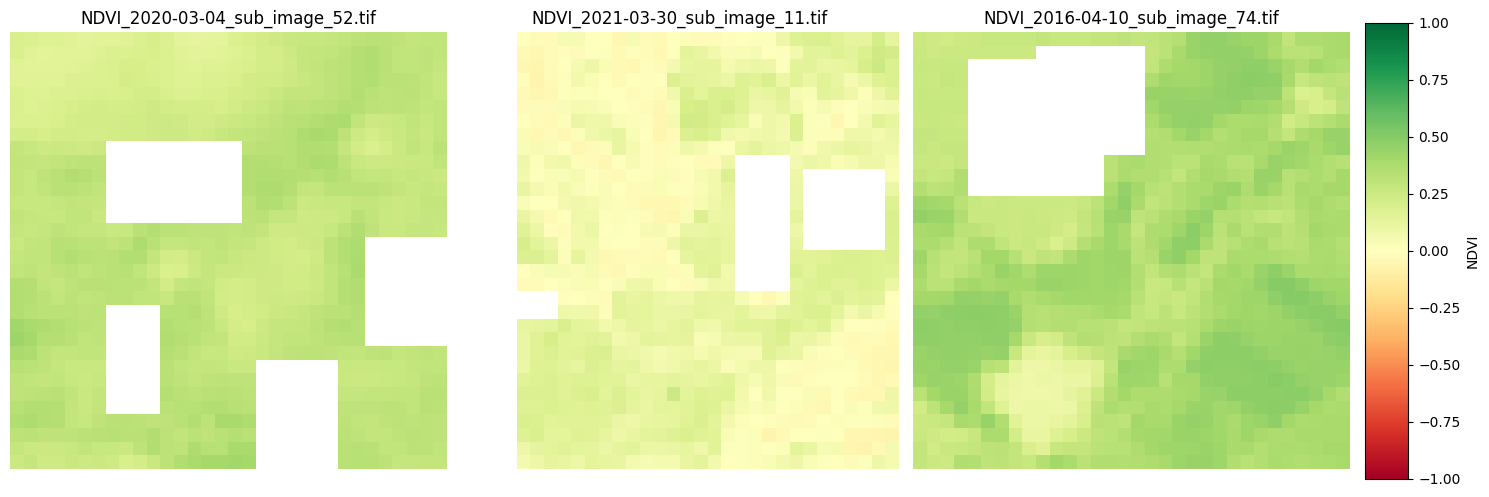

In [36]:
# Get a list of files in the directory
tif_files = [f for f in os.listdir(train_with_holes_dir) if f.endswith('.tif')]

# Specify the indices of images you want to display
selected_indices = [0, 50, 1000 ]

# Safeguard: Ensure indices are within range
selected_files = [tif_files[i] for i in selected_indices if i < len(tif_files)]

# Set up a GridSpec layout
fig = plt.figure(figsize=(15, 5))
gs = GridSpec(1, len(selected_files) + 1, width_ratios=[1] * len(selected_files) + [0.1])  # Extra column for the colorbar

axes = [fig.add_subplot(gs[0, i]) for i in range(len(selected_files))]  # Subplots for images
cbar_ax = fig.add_subplot(gs[0, -1])  # Separate subplot for the colorbar

for i, file_name in enumerate(selected_files):
    file_path = os.path.join(train_with_holes_dir, file_name)

    # Open the GeoTIFF file
    with rasterio.open(file_path) as src:
        ndvi_data = src.read(1)  # Read the first band (NDVI values)
        ndvi_data = np.where(ndvi_data == src.nodata, np.nan, ndvi_data)  # Handle NoData values

    # Plot the NDVI data in the subplot
    im = axes[i].imshow(ndvi_data, cmap='RdYlGn', vmin=-1, vmax=1)
    axes[i].set_title(file_name)
    axes[i].axis('off')

# Add the shared colorbar in the dedicated axis
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
cbar.set_label('NDVI')

# Adjust layout
plt.tight_layout()
plt.show()

##### 2.4.1 Pairing the complete images with the images with holes (train and validation)

In [38]:
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
!pip install keras-tuner
import keras_tuner as kt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.5 MB/s eta 0:00:00


In [39]:
def load_and_pair_images(input_dir, target_dir):
    """Load original images and images with holes, and pair them."""
    image_pairs = []
    for filename in os.listdir(input_dir):
        if filename.endswith('.tif'):
            input_path = os.path.join(input_dir, filename)
            target_path = os.path.join(target_dir, filename)

            # Load images
            input_img = cv2.imread(input_path, cv2.IMREAD_UNCHANGED)
            target_img = cv2.imread(target_path, cv2.IMREAD_UNCHANGED)

            if input_img is not None and target_img is not None:
                image_pairs.append((input_img, target_img))
            else:
                print(f"Failed to load {filename}. Skipping...")
    return image_pairs

In [40]:
# Load and pair the training data
train_data = load_and_pair_images(train_dir, train_with_holes_dir)

# Load and pair validation images with holes
val_data = load_and_pair_images(val_dir, val_with_holes_dir)

Failed to load NDVI_2022-02-13 (1)_sub_image_87.tif. Skipping...
Failed to load NDVI_2013-07-14_sub_image_14.tif. Skipping...
Failed to load NDVI_2015-05-10_sub_image_1.tif. Skipping...
Failed to load NDVI_2013-11-12_sub_image_17.tif. Skipping...
Failed to load NDVI_2022-02-13 (1)_sub_image_83.tif. Skipping...
Failed to load NDVI_2016-08-23_sub_image_5.tif. Skipping...
Failed to load NDVI_2013-07-14_sub_image_10.tif. Skipping...
Failed to load NDVI_2018-06-26_sub_image_72.tif. Skipping...
Failed to load NDVI_2022-09-18_sub_image_18.tif. Skipping...
Failed to load NDVI_2023-08-20_sub_image_50.tif. Skipping...
Failed to load NDVI_2022-02-13 (1)_sub_image_54.tif. Skipping...
Failed to load NDVI_2014-06-08_sub_image_10.tif. Skipping...
Failed to load NDVI_2014-06-08_sub_image_11.tif. Skipping...
Failed to load NDVI_2015-08-21_sub_image_12.tif. Skipping...
Failed to load NDVI_2013-11-12_sub_image_8.tif. Skipping...
Failed to load NDVI_2013-11-12_sub_image_84.tif. Skipping...
Failed to load 

##### 2.4.2 Data conversion and normalization

In [41]:
# Training set
# Convert to numpy arrays
X_train = np.array([pair[0] for pair in train_data])
y_train = np.array([pair[1] for pair in train_data])

# Normalize the images (values between -1 and 1)
X_train = X_train / 255.0
y_train = y_train / 255.0

In [42]:
#Validation set
# Convert to numpy arrays
X_val = np.array([pair[0] for pair in val_data])
y_val = np.array([pair[1] for pair in val_data])

# Normalize validation data
X_val = X_val / 255.0
y_val = y_val / 255.0

##### 2.4.3 Building the U-Net CNN Model for Image Inpainting

In [43]:
from tensorflow.keras import layers, models

In [44]:
def build_unet_model(input_shape):
    """Build a simple U-Net model."""
    inputs = layers.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)

    # Bottleneck
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)

    # Decoder
    up3 = layers.UpSampling2D((2, 2))(conv2)
    conv3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up3)

    # Output layer
    output = layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same')(conv3)

    # Compile model
    model = models.Model(inputs, output)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return model

In [45]:
# Define the model input shape (32x32 pixels and 1 channel)
model = build_unet_model((32, 32, 1))

##### 2.4.4 Hyperparameter optimization using Keras tuner

In [46]:
def model_builder(hp):
    """Build a model with hyperparameter tuning."""
    model = build_unet_model((32, 32, 1))

    # Tune the learning rate
    model.compile(optimizer=tf.keras.optimizers.Adam(
        hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')
    ), loss='mse', metrics=['mae'])

    return model

In [47]:
# Initialize the Hyperband tuner
tuner = kt.Hyperband(
    model_builder,
    objective='val_loss',
    max_epochs=10,
    factor=3,
    directory='hyperparameter_tuning',
    project_name='ndvi_inpainting'
)

In [48]:
# Perform Hyperparameter Search
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=8)

Trial 2 Complete [00h 08m 47s]
val_loss: nan

Best val_loss So Far: nan
Total elapsed time: 00h 17m 40s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
0.0006164         |0.00097599        |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 257s 248ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 2/2
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 257s 243ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan


RuntimeError: Number of consecutive failures exceeded the limit of 3.


In [49]:
# Get the best Hyperparameters
best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best learning rate: ", best_hp['learning_rate'])

Best learning rate:  0.0009759853564369572


##### 2.4.5 Train the model with the best Hyperparameters

In [50]:
best_model = tuner.hypermodel.build(best_hp)

# Set up callbacks to monitor progress
history = best_model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), batch_size=8)


Epoch 1/50
 155/1027 ━━━━━━━━━━━━━━━━━━━━ 3:34 246ms/step - loss: nan - mae: nan

KeyboardInterrupt: 

In [ ]:
# Save the model
best_model.save('/content/drive/My Drive/NDVI_Landsat8_10/best_unet_model')

##### 2.4.6 Loss and Accuracy Graphs

In [ ]:
def plot_history(history, save_path):
    """Plot loss and accuracy over epochs and save the plots."""
    plt.figure(figsize=(12, 6))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot MAE (Mean Absolute Error)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Mean Absolute Error (MAE)')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()

    # Save the plots to file
    plt.savefig(save_path)
    plt.close()

In [ ]:
plot_history(history, '/content/drive/My Drive/NDVI_Landsat8_10/training_history.png')